In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

100%|██████████| 9.91M/9.91M [00:13<00:00, 717kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 332kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.80MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [5]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        # inherit from nn.Module
        super().__init__()
        # The model architecture
        self.input_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.hidden_convolution1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.hidden_convolution2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.activation3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.hidden_convolution3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.activation4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.hidden_linear= nn.Linear(in_features=256, out_features=1024)
        self.activation5 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation1(x)
        x = self.maxpool1(x)
        x = self.hidden_convolution1(x)
        x = self.activation2(x)
        x = self.maxpool2(x)
        x = self.hidden_convolution2(x)
        x = self.activation3(x)
        x = self.maxpool3(x)
        x = self.hidden_convolution3(x)
        x = self.activation4(x)
        x = self.maxpool4(x)
        x = self.flatten(x)
        x = self.hidden_linear(x)
        x = self.activation3(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [7]:
model = NeuralNetwork()
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 10])

In [8]:
model(x)

tensor([[-0.0320,  0.0266, -0.0032,  0.0234,  0.0381, -0.0209,  0.0141, -0.0098,
         -0.0228, -0.0272],
        [-0.0259,  0.0178, -0.0079,  0.0252,  0.0332,  0.0072,  0.0220, -0.0248,
          0.0066, -0.0129],
        [-0.0343, -0.0146,  0.0128,  0.0239,  0.0493, -0.0095,  0.0359,  0.0173,
         -0.0178, -0.0098],
        [-0.0346, -0.0126,  0.0050,  0.0088,  0.0594, -0.0193,  0.0340, -0.0088,
          0.0067,  0.0183]], grad_fn=<AddmmBackward0>)

In [9]:
print(model)

NeuralNetwork(
  (input_layer): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_convolution1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_convolution2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden_convolution3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_linear): Linear(in_features=256, out_features=1024, bias=True)
  (activation5): ReLU()
  (dropout): Dropout(p=0.5, inpl

In [10]:
on_gpu = True
if on_gpu:
  device = torch.device("cuda")
  model = model.to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
def train(model, num_epochs, train_dl, valid_dl):
    # Set up logging data containers
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        # Put the model in training mode, so that
        # weights can be adjusted
        model.train()
        for x_batch, y_batch in train_dl:
            if on_gpu:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        # Put the model in evaluation mode, no
        # weights are adjusted here.
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                if on_gpu:
                  x_batch = x_batch.to(device)
                  y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = criterion(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [14]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9932 val_accuracy: 0.9891
Epoch 2 accuracy: 0.9942 val_accuracy: 0.9891
Epoch 3 accuracy: 0.9947 val_accuracy: 0.9844
Epoch 4 accuracy: 0.9963 val_accuracy: 0.9902
Epoch 5 accuracy: 0.9958 val_accuracy: 0.9868
Epoch 6 accuracy: 0.9960 val_accuracy: 0.9898
Epoch 7 accuracy: 0.9964 val_accuracy: 0.9897
Epoch 8 accuracy: 0.9970 val_accuracy: 0.9874
Epoch 9 accuracy: 0.9972 val_accuracy: 0.9898
Epoch 10 accuracy: 0.9973 val_accuracy: 0.9891
Epoch 11 accuracy: 0.9974 val_accuracy: 0.9894
Epoch 12 accuracy: 0.9979 val_accuracy: 0.9876
Epoch 13 accuracy: 0.9973 val_accuracy: 0.9899
Epoch 14 accuracy: 0.9977 val_accuracy: 0.9880
Epoch 15 accuracy: 0.9976 val_accuracy: 0.9899
Epoch 16 accuracy: 0.9977 val_accuracy: 0.9885
Epoch 17 accuracy: 0.9982 val_accuracy: 0.9905
Epoch 18 accuracy: 0.9979 val_accuracy: 0.9894
Epoch 19 accuracy: 0.9981 val_accuracy: 0.9898
Epoch 20 accuracy: 0.9982 val_accuracy: 0.9904


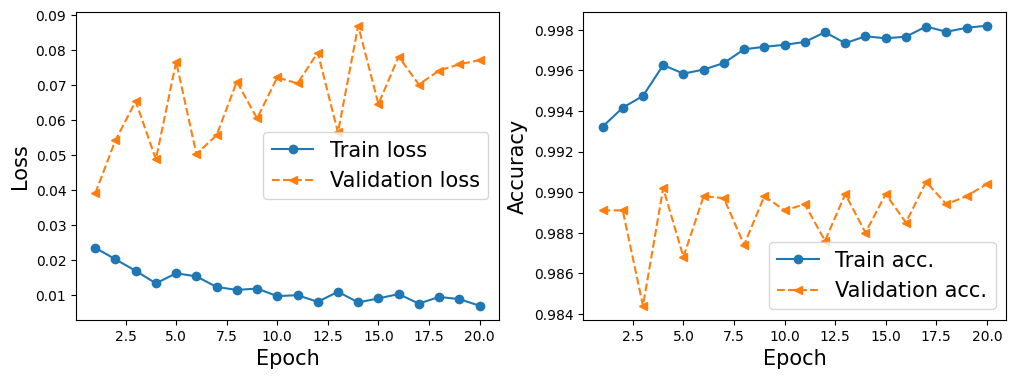

In [15]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [17]:
torch.save(model.state_dict(), "cnn_model_1.pth")